In [73]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

Generar un grafo a partir de la versión .csv del elliptic dataset. 

Graficar, visualizar, y comparar con el grafo que viene por defecto en la librería torch-geometric. 

Analizar las variables asociadas a cada id involucrado en las transacciones.

# Construcción del grafo a partir de Elliptic Graph Dataset y análisis exploratorio 

El dataset que usaremos es una variante del Elliptic Data Set, presentado por Weber et al. en 2019 [1] con datos provistos por Elliptic [2]. 

Se trata de un dataset con datos de más de 234 mil transacciones de Bitcoin entre más de 200 mil nodos. 

Una proporción de esas transacciones fueron etiquetadas como fraudulentas o no fraudulentas, mientras que de la mayoría se desconoce su etiqueta. 

También se incluyen 165 features anonimizadas de cada transacción. 

In [74]:
# 1. Cargar el CSV
df = pd.read_csv("../data/elliptic_graph_dataset.csv")

## Análisis preliminar del dataset

In [75]:
df.columns

Index(['person_id_from', 'person_id_to', 'fraud_label', 'feature_0',
       'feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_5',
       'feature_6',
       ...
       'feature_155', 'feature_156', 'feature_157', 'feature_158',
       'feature_159', 'feature_160', 'feature_161', 'feature_162',
       'feature_163', 'feature_164'],
      dtype='object', length=168)

In [76]:
df.head()

,person_id_from,person_id_to,fraud_label,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,...,feature_155,feature_156,feature_157,feature_158,feature_159,feature_160,feature_161,feature_162,feature_163,feature_164
0,0,1,2,-0.171469,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,...,-0.562153,-0.600999,1.461330,1.461369,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
1,2,3,2,-0.172107,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,...,0.670883,0.439728,-0.979074,-0.978556,-0.098889,-0.106715,-0.131155,-0.183671,-0.120613,-0.119792
2,4,5,2,1.011523,-0.081127,-1.201369,1.153668,0.333276,1.312656,-0.061584,...,-0.511871,-0.400422,0.517257,0.579381,0.018279,0.277775,0.326394,1.293750,0.178136,0.179117
3,6,7,2,-0.171264,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,...,-0.569626,-0.607306,-0.979074,-0.978556,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
4,8,9,2,-0.123127,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,...,-0.128722,-0.235168,-0.979074,-0.978556,-0.098889,-0.087490,-0.084674,-0.140597,1.519700,1.521400


## Columnas del dataset

- person_id_from: nodo origen (quien envía)

- person_id_to: nodo destino (quien recibe)

- fraud_label: etiqueta de fraude (1 = fraudulento, 0 = no fraudulento, 2 = deconocida)

- feature_0 a feature_164: características del nodo origen o de la transacción

In [106]:
# ¿Hay múltiples vectores de features para un mismo person_id_from?
df.groupby('person_id_from')[[f'feature_{i}' for i in range(165)]].nunique().max().max()


np.int64(1)

La prueba anterior nos indica que las features corresponden a datos del nodo de origen de la transacción, no del nodo destino. 

### Valores nulos

In [78]:

# Seleccionar solo las columnas de features
feature_cols = [f'feature_{i}' for i in range(165)]  # o 165 si estás seguro de que llegan a feature_164

# Calcular cantidad y porcentaje de nulos por columna
null_counts = df[feature_cols].isnull().sum()
null_percent = (null_counts / len(df)) * 100

# Unir en un solo DataFrame para inspección
null_summary = pd.DataFrame({
    'null_count': null_counts,
    'null_percent': null_percent
}).sort_values(by='null_percent', ascending=False)

print(null_summary.head(10))  # Las 10 features con más nulos


           null_count  null_percent
feature_0           0           0.0
feature_1           0           0.0
feature_2           0           0.0
feature_3           0           0.0
feature_4           0           0.0
feature_5           0           0.0
feature_6           0           0.0
feature_7           0           0.0
feature_8           0           0.0
feature_9           0           0.0


No se encuentran valores nulos.

## Construcción del grafo

Se trata de un grafo dirigido ya que los nexos entre los nodos no son recíprocos sino que tienen un origen y un destino. 

Las `features` se aplican al nodo de origen. 

La `fraud_label` se aplica al nexo entre los nodos. 

In [79]:
# 2. Crear el grafo dirigido (el flujo tiene dirección)
G = nx.DiGraph()

In [80]:
# 3. Agregar nodos y aristas
for _, row in df.iterrows():
    src = row['person_id_from']
    dst = row['person_id_to']
    
    # Agregar nodos si no existen, con sus features
    if src not in G:
        features_src = row[[f'feature_{i}' for i in range(165)]].tolist()
        G.add_node(src, features=features_src)
    if dst not in G:
        # Podés asignar features vacías si no tenés info del nodo destino
        G.add_node(dst, features=[None]*165)

    # Agregar arista con la etiqueta de fraude
    G.add_edge(src, dst, fraud_label=row['fraud_label'])

# Verificamos que el numero de nodos y aristas coinciden con lo esperado 
print(f"Nodos: {G.number_of_nodes()}, Aristas: {G.number_of_edges()}")



Nodos: 203769, Aristas: 234355


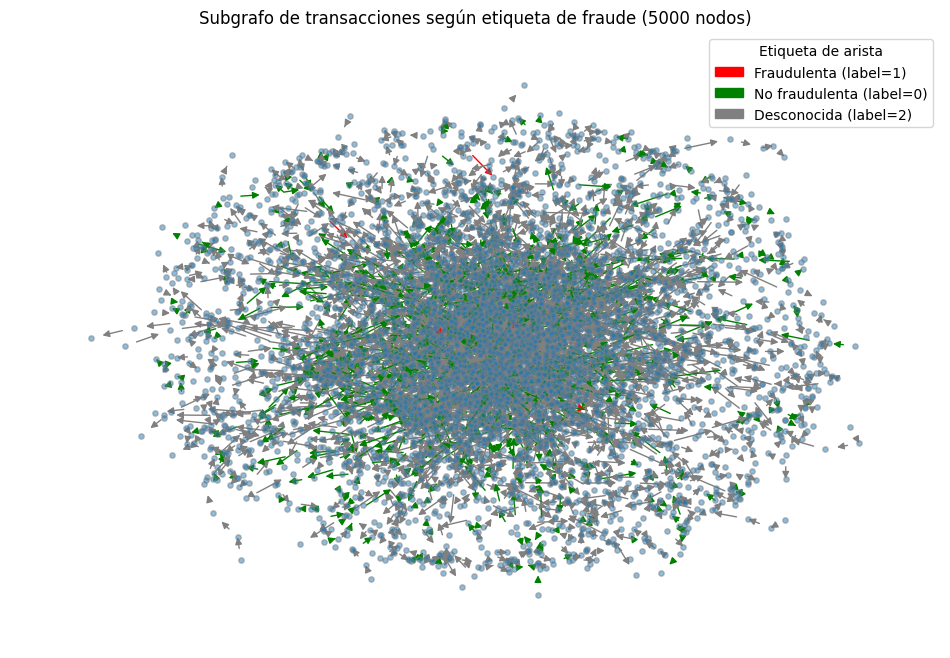

In [236]:
# 4. Visualizar una parte del grafo (opcional)
subgraph = G.subgraph(list(G.nodes)[:5000])  # muestra 5000 nodos
pos = nx.fruchterman_reingold_layout(subgraph, seed=42)
plt.figure(figsize=(12, 8))  

# Colores según si la arista es fraudulenta
edge_colors = []
for u, v in subgraph.edges():
    label = subgraph[u][v].get('fraud_label')
    if label == 1:
        edge_colors.append('red')
    elif label == 0:
        edge_colors.append('green')
    else:
        edge_colors.append('gray')

# nodes
options = {"edgecolors": "tab:gray", "node_size": 15, "alpha": 0.5}
nx.draw_networkx_nodes(subgraph, pos, **options)

# edges
nx.draw_networkx_edges(subgraph, pos, width=1.0, alpha=1, edge_color=edge_colors)

plt.title("Subgrafo de transacciones según etiqueta de fraude (5000 nodos)")

import matplotlib.patches as mpatches

# Definir parches de color para la leyenda
legend_elements = [
    mpatches.Patch(color='red', label='Fraudulenta (label=1)'),
    mpatches.Patch(color='green', label='No fraudulenta (label=0)'),
    mpatches.Patch(color='gray', label='Desconocida (label=2)')
]
plt.axis('off')

plt.legend(handles=legend_elements, loc='upper right', title="Etiqueta de arista")
plt.show()


## Análisis exploratorio del grafo

### In-degrees y out-degrees

In [82]:
# Extraer grados
in_degrees = dict(G.in_degree())
out_degrees = dict(G.out_degree())

# Convertir a DataFrame para análisis
degree_df = pd.DataFrame({
    'node': list(G.nodes()),
    'in_degree': [in_degrees[n] for n in G.nodes()],
    'out_degree': [out_degrees[n] for n in G.nodes()]
})

In [83]:
# Estadísticas básicas
desc_stats = degree_df[['in_degree', 'out_degree']].describe()
print(desc_stats)


           in_degree     out_degree
count  203769.000000  203769.000000
mean        1.150101       1.150101
std         3.911132       1.894740
min         0.000000       0.000000
25%         0.000000       1.000000
50%         1.000000       1.000000
75%         1.000000       1.000000
max       284.000000     472.000000


#### Nodos con mayor in-degree y out-degree

In [142]:
print("Nodos con mayor in-degree:")
print(degree_df.sort_values('in_degree', ascending=False).head())

print("\nNodos con mayor out-degree:")
print(degree_df.sort_values('out_degree', ascending=False).head())


Nodos con mayor in-degree:
            node  in_degree  out_degree
51483    51371.0        284           0
51377    51437.0        247           0
148195  148292.0        241           0
35892    35892.0        239           0
24761    24761.0        212           0

Nodos con mayor out-degree:
            node  in_degree  out_degree
94301    94301.0          1         472
130        130.0          1         288
141818  141786.0          0         122
133793  133793.0          1         112
198381  198381.0          1          99


Se observa que la mayoría de los nodos (al menos el 75%) tiene sólo un nexo, pero algunos pocos nodos tienen decenas o cientos, con un máximo de 284 nexos entrantes y 472 nexos salientes. 

### Tipos de conexiones

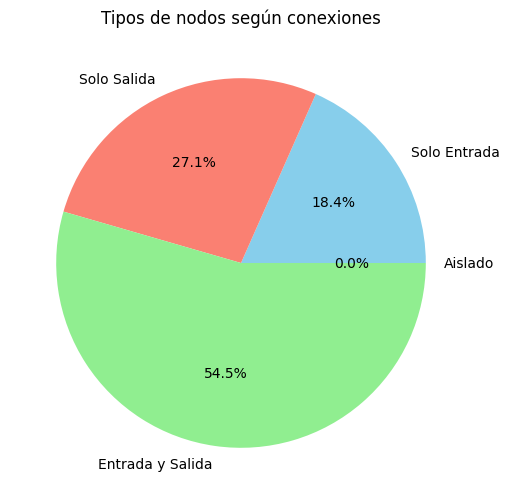

In [85]:
only_in = 0
only_out = 0
both = 0
isolated = 0

for n in G.nodes():
    in_d = G.in_degree(n)
    out_d = G.out_degree(n)
    
    if in_d > 0 and out_d == 0:
        only_in += 1
    elif in_d == 0 and out_d > 0:
        only_out += 1
    elif in_d > 0 and out_d > 0:
        both += 1
    else:
        isolated += 1

# Pie chart
labels = ['Solo Entrada', 'Solo Salida', 'Entrada y Salida', 'Aislado']
sizes = [only_in, only_out, both, isolated]
colors = ['skyblue', 'salmon', 'lightgreen', 'gray']

plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%')
plt.title("Tipos de nodos según conexiones")
plt.show()


### Etiquetas de transacciones

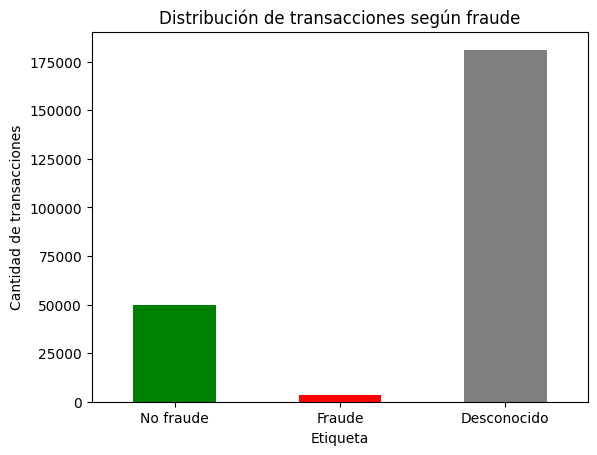

In [144]:
# Contar etiquetas de fraude en las aristas
labels = nx.get_edge_attributes(G, 'fraud_label')
fraud_counts = pd.Series(labels.values()).value_counts().sort_index()

# Reemplazar valores para que sean más claros
fraud_counts.index = fraud_counts.index.map({2: 'Desconocido', 1: 'Fraude', 0: 'No fraude'})

# Bar chart
fraud_counts.plot(kind='bar', color=['green', 'red', 'gray'])
plt.title("Distribución de transacciones según fraude")
plt.ylabel("Cantidad de transacciones")
plt.xlabel("Etiqueta")
plt.xticks(rotation=0)
plt.show()


In [146]:
from collections import defaultdict

fraud_out = defaultdict(int)
fraud_in = defaultdict(int)

for u, v, data in G.edges(data=True):
    label = data.get('fraud_label')
    if label == 1:  # Solo fraude confirmado
        fraud_out[u] += 1
        fraud_in[v] += 1


In [147]:
in_degrees = dict(G.in_degree())
out_degrees = dict(G.out_degree())

nodes_df = pd.DataFrame({
    'node': list(G.nodes()),
    'in_degree': [in_degrees[n] for n in G.nodes()],
    'out_degree': [out_degrees[n] for n in G.nodes()],
    'fraud_in': [fraud_in[n] for n in G.nodes()],
    'fraud_out': [fraud_out[n] for n in G.nodes()],
})

# Total y proporción de fraude
nodes_df['fraud_total'] = nodes_df['fraud_in'] + nodes_df['fraud_out']
nodes_df['fraud_ratio_in'] = nodes_df['fraud_in'] / nodes_df['in_degree'].replace(0, pd.NA)
nodes_df['fraud_ratio_out'] = nodes_df['fraud_out'] / nodes_df['out_degree'].replace(0, pd.NA)



### Relación entre grados y etiqueta de fraude

Solo transacciones con etiqueta conocida

In [149]:
fraud_out = defaultdict(int)
fraud_in = defaultdict(int)

for u, v, data in G.edges(data=True):
    label = data.get('fraud_label')
    if label in [0, 1]:  # solo etiquetas conocidas
        if label == 1:   # solo contamos fraude para este análisis
            fraud_out[u] += 1
            fraud_in[v] += 1


In [150]:
from collections import defaultdict

# Inicializamos contadores
known_out = defaultdict(int)
known_in = defaultdict(int)

# Contamos solo transacciones con label conocido
for u, v, data in G.edges(data=True):
    label = data.get('fraud_label')
    if label in [1, 2]:
        known_out[u] += 1
        known_in[v] += 1


In [151]:
# Grados de entrada y salida generales (todas las aristas)
in_degrees = dict(G.in_degree())
out_degrees = dict(G.out_degree())

# DataFrame
nodes_df = pd.DataFrame({
    'node': list(G.nodes()),
    'in_degree': [in_degrees[n] for n in G.nodes()],
    'out_degree': [out_degrees[n] for n in G.nodes()],
    'fraud_in': [fraud_in[n] for n in G.nodes()],
    'fraud_out': [fraud_out[n] for n in G.nodes()],
    'known_in': [known_in[n] for n in G.nodes()],
    'known_out': [known_out[n] for n in G.nodes()]
})

# Proporción de fraude sobre transacciones con etiqueta conocida

nodes_df['fraud_ratio_in'] = nodes_df['fraud_in'] / nodes_df['known_in'].replace(0, np.nan)
nodes_df['fraud_ratio_out'] = nodes_df['fraud_out'] / nodes_df['known_out'].replace(0, np.nan)



Si out_degree correlaciona positivamente con fraud_ratio_out → los nodos que más envían transacciones tienden a cometer más fraude

Si fraud_ratio_in está negativamente correlacionado con in_degree → los nodos que reciben menos transacciones tienen más riesgo de recibir fraude

In [152]:
# Correlaciones entre grado y proporción de fraude
correlation_matrix = nodes_df[['in_degree', 'out_degree', 'fraud_ratio_in', 'fraud_ratio_out']].corr()
print(correlation_matrix)


                 in_degree  out_degree  fraud_ratio_in  fraud_ratio_out
in_degree         1.000000   -0.010265        0.023477        -0.015405
out_degree       -0.010265    1.000000       -0.024837        -0.030567
fraud_ratio_in    0.023477   -0.024837        1.000000         0.563150
fraud_ratio_out  -0.015405   -0.030567        0.563150         1.000000


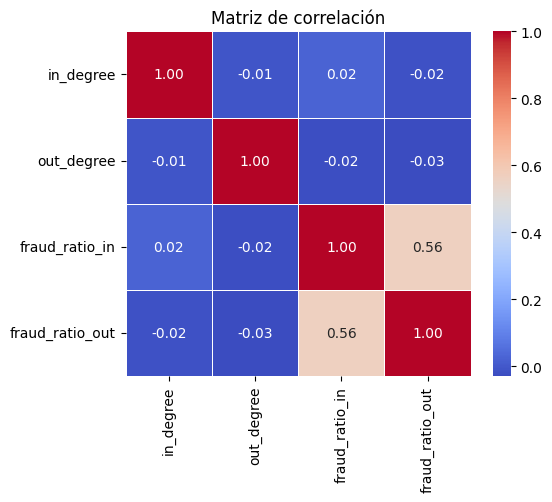

In [153]:
import seaborn as sns
# Seleccionamos columnas numéricas relevantes
corr_data = nodes_df[['in_degree', 'out_degree', 'fraud_ratio_in', 'fraud_ratio_out']]

# Calculamos la matriz de correlación
corr_matrix = corr_data.corr()

# Heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True, linewidths=0.5)
plt.title("Matriz de correlación")
plt.tight_layout()
plt.show()


No se halla una correlación entre los grados salientes y entrantes y la probabilidad de fraude. 

Sin embargo, sí se observa una correlación positiva entre la probabilidad de un nodo de ser destino y origen de una transacción fraudulenta (`raud_ratio_in` y `fraud_ratio_out` respectivamente).

Esta correlación podría reflejar comportamientos en cadena sin intencionalidad (nodos que reciben BTC de origen fraudulento y luego lo redistribuyen), así como participación activa en fraude(nodos que forman parte de una red de lavado o dispersión de fondos fraudulentos). 

#### Fraude entrante y saliente por nodo

In [165]:
# valores absolutos
print(nodes_df[['fraud_in', 'fraud_out']].describe())


            fraud_in      fraud_out
count  203769.000000  203769.000000
mean        0.016543       0.016543
std         0.448516       0.138863
min         0.000000       0.000000
25%         0.000000       0.000000
50%         0.000000       0.000000
75%         0.000000       0.000000
max        68.000000       3.000000


In [166]:
# proporción sobre etiquetas conocidas
print(nodes_df[['fraud_ratio_in', 'fraud_ratio_out']].describe())


       fraud_ratio_in  fraud_ratio_out
count   123103.000000    134631.000000
mean         0.010616         0.022766
std          0.100002         0.149157
min          0.000000         0.000000
25%          0.000000         0.000000
50%          0.000000         0.000000
75%          0.000000         0.000000
max          1.000000         1.000000


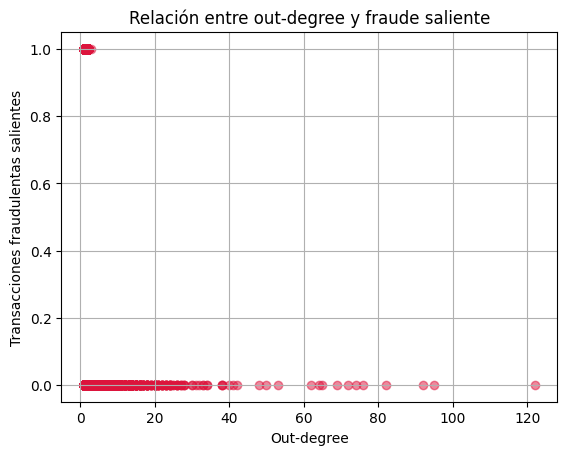

In [170]:

plt.scatter(nodes_df['out_degree'], nodes_df['fraud_ratio_out'], alpha=0.5, color='crimson')
plt.xlabel("Out-degree")
plt.ylabel("Transacciones fraudulentas salientes")
plt.title("Relación entre out-degree y fraude saliente")
plt.grid(True)
plt.show()


En el gráfico anterior vemos que los nodos que presentan transacciones etiquetadas como fraudulentas presentan valores bajos de out_degree. 

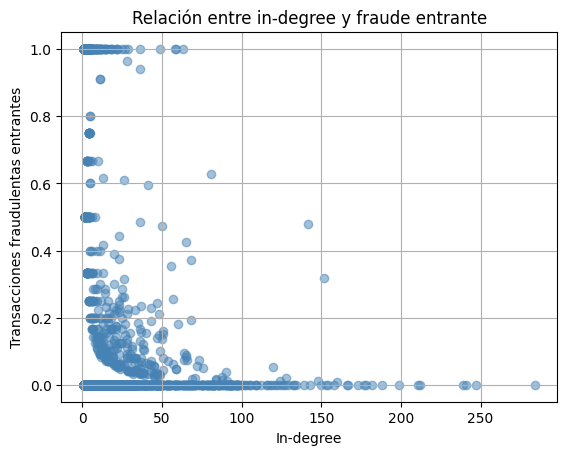

In [169]:
plt.scatter(nodes_df['in_degree'], nodes_df['fraud_ratio_in'], alpha=0.5, color='steelblue')
plt.xlabel("In-degree")
plt.ylabel("Transacciones fraudulentas entrantes")
plt.title("Relación entre in-degree y fraude entrante")
plt.grid(True)
plt.show()


En el gráfico se observa que los nodos cuya totalidad de transacciones entrantes etiquetadas son fraudulentas presentan un in-degree menor a 75.

Además, ningún nodo con un in-degree superior a 175 recibió transacciones entrantes etiquetadas como fraudulentas.

## Comparación con grafo de torch-geom

In [173]:
from torch_geometric.datasets import Reddit

dataset = Reddit(root='data/Reddit')
data = dataset[0]

print(f"Nodos: {data.num_nodes}")
print(f"Aristas: {data.num_edges}")
print(f"¿Es dirigido? {not data.is_undirected()}")


Extracting data/Reddit/raw/reddit.zip
Processing...
Done!


Nodos: 232965
Aristas: 114615892
¿Es dirigido? False


In [174]:
from torch_geometric.utils import degree

# Calcula el grado de cada nodo
deg = degree(data.edge_index[0], data.num_nodes)

print(f"Grado promedio: {deg.mean():.2f}")
print(f"Grado máximo: {deg.max():.0f}")
print(f"Grado mínimo: {deg.min():.0f}")


Grado promedio: 491.99
Grado máximo: 21657
Grado mínimo: 1


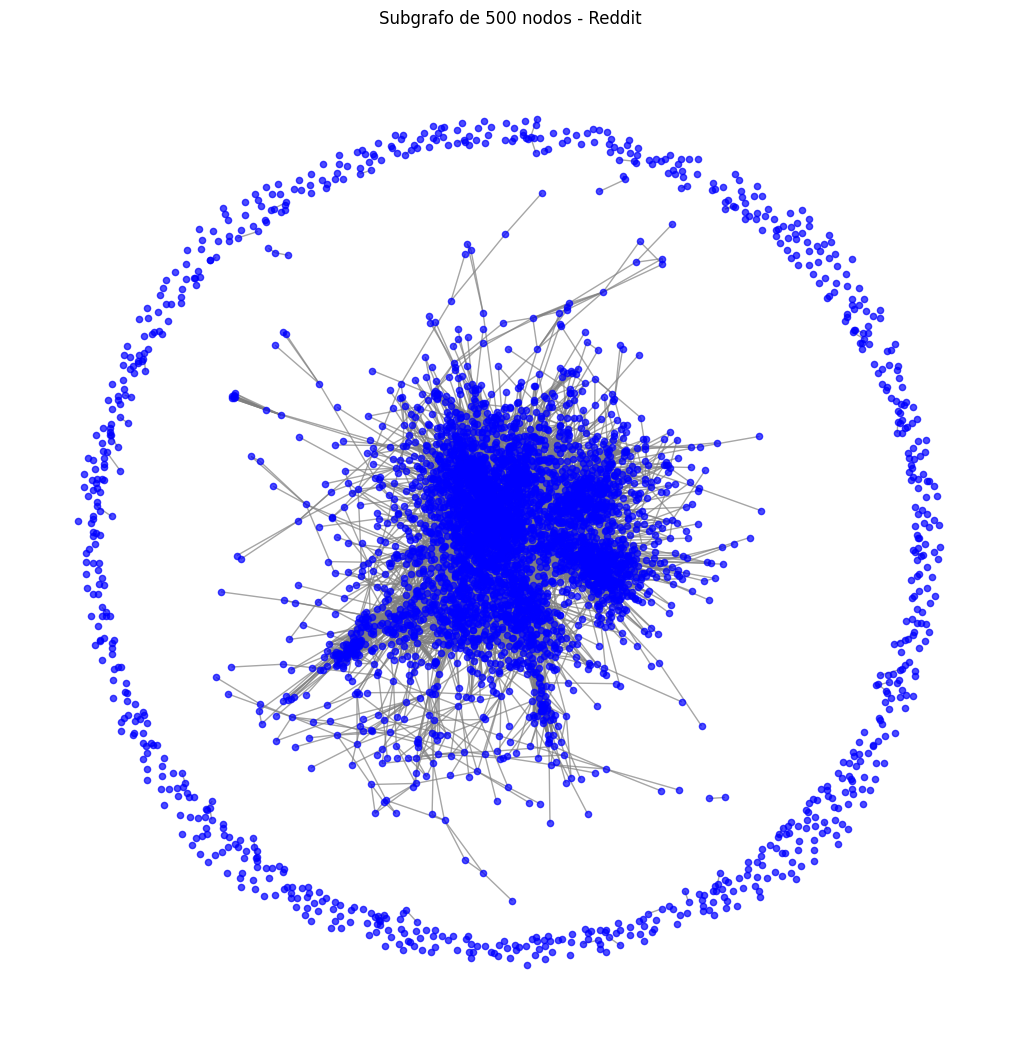

In [176]:
from torch_geometric.utils import subgraph, to_networkx
import matplotlib.pyplot as plt
import torch
import networkx as nx

# Cargar dataset
dataset = Reddit(root='data/Reddit')
data = dataset[0]

# Seleccionar 500 nodos consecutivos (por ejemplo, los primeros 500)
num_nodes_subgraph = 5000
subset = torch.arange(num_nodes_subgraph)

# Extraer el subgrafo induced (nodos y aristas entre ellos)
edge_index_sub, node_mask = subgraph(subset, data.edge_index, relabel_nodes=True)

# Crear objeto Data para el subgrafo
from torch_geometric.data import Data
sub_data = Data(x=data.x[subset], edge_index=edge_index_sub)

# Convertir a NetworkX para graficar
G_sub = to_networkx(sub_data, to_undirected=True)

# Graficar
plt.figure(figsize=(10, 10))
pos = nx.spring_layout(G_sub, seed=42)  # layout para mejor visualización
nx.draw(G_sub, pos, node_size=20, node_color='blue', edge_color='gray', alpha=0.7)
plt.title("Subgrafo de 500 nodos - Reddit")
plt.show()


## Análisis de features

In [179]:
features = [col for col in df.columns if col.startswith('feature_')]
print(df[features].describe().T)


                count      mean        std       min       25%       50%  \
feature_0    234355.0  0.101846   1.443885 -0.172983 -0.172074 -0.164507   
feature_1    234355.0  0.235442   2.274191 -0.210553 -0.178377 -0.120990   
feature_2    234355.0  0.059561   1.057229 -1.756361 -1.201369  0.463609   
feature_3    234355.0  0.025701   0.884004 -0.121970 -0.121970 -0.121970   
feature_4    234355.0  1.047977  11.220102 -0.063725 -0.043875 -0.043875   
...               ...       ...        ...       ...       ...       ...   
feature_160  234355.0  0.286951   2.701760 -0.106715 -0.087490 -0.087490   
feature_161  234355.0  0.082132   1.380130 -0.131155 -0.131155 -0.084674   
feature_162  234355.0  0.026940   0.745402 -0.183671 -0.140597 -0.097524   
feature_163  234355.0  0.000304   0.958896 -1.760927 -0.120613 -0.120613   
feature_164  234355.0 -0.001256   0.959055 -1.760984 -0.119792 -0.119792   

                  75%         max  
feature_0   -0.082223   71.681970  
feature_1   -0.

### Matriz de correlación

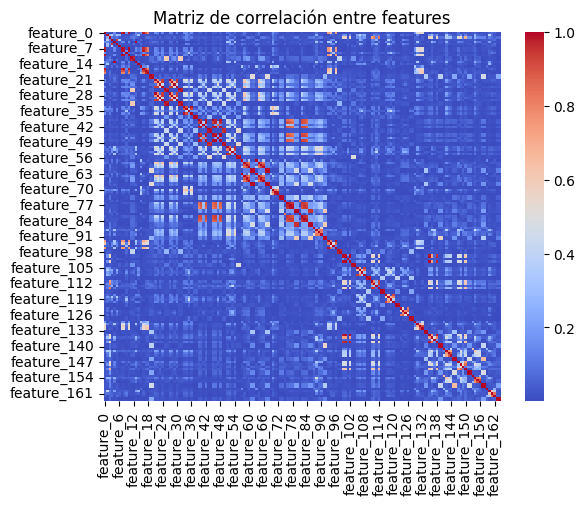

In [228]:
corr_matrix = df[features].corr().abs()
sns.heatmap(corr_matrix, cmap='coolwarm', vmax=1.0)
plt.title("Matriz de correlación entre features")
plt.show()


### Reducción de dimensionalidad

Para estudiar la estructura de los datos, realizaremos un análisis de reducción de dimensionalidad que nos permita visualizar los datos en dos dimensiones. 

In [ ]:
from sklearn.preprocessing import StandardScaler

# escalamos los datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[features])


In [ ]:
import numpy as np
# removemos outliers (5 desviaciones estandar, poco estricto)
z_scores = np.abs((X_scaled - X_scaled.mean(axis=0)) / X_scaled.std(axis=0))
mask = (z_scores < 5).all(axis=1)
X_clean = X_scaled[mask]
df_clean = df.loc[mask]


In [222]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_clean)

df_clean['pca_1'] = X_pca[:, 0]
df_clean['pca_2'] = X_pca[:, 1]


/tmp/ipykernel_2616/2860099559.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['pca_1'] = X_pca[:, 0]
/tmp/ipykernel_2616/2860099559.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['pca_2'] = X_pca[:, 1]


In [223]:
df_clean.shape, df.shape

((200857, 171), (234355, 171))

/tmp/ipykernel_2616/1090401354.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['fraud_label_str'] = df_clean['fraud_label'].map({


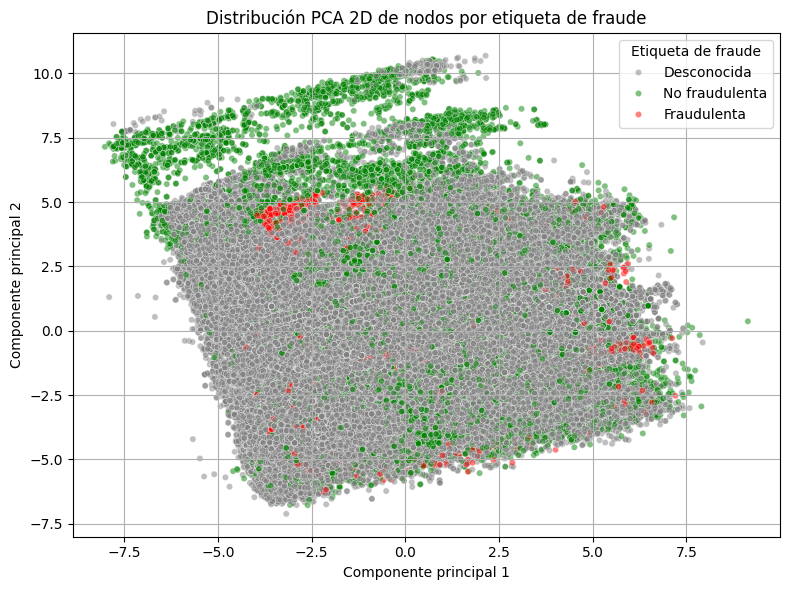

In [225]:

# Mapeo para etiquetas legibles
df_clean['fraud_label_str'] = df_clean['fraud_label'].map({
    1: 'Fraudulenta',
    0: 'No fraudulenta',
    2: 'Desconocida'
})

# Gráfico
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=df_clean,
    x='pca_1',
    y='pca_2',
    hue='fraud_label_str',
    palette={'Fraudulenta': 'red', 'No fraudulenta': 'green', 'Desconocida': 'gray'},
    alpha=0.5,
    s=20
)

plt.title("Distribución PCA 2D de nodos por etiqueta de fraude")
plt.xlabel("Componente principal 1")
plt.ylabel("Componente principal 2")
plt.legend(title="Etiqueta de fraude")
plt.grid(True)
plt.tight_layout()
plt.show()


Vemos que las transacciones etiquetadas como fraudulentas tienden a agruparse. Esto sugiere que las 2 componentes principales contienen patrones útiles para detectar fraude. 

Concluimos que la estructura de los datos es adecuada para entrenar un modelo de clasificación supervisado. 

In [230]:
from typing import Any, Callable, List, Optional, Tuple

import torch

from torch_geometric.data import Data, InMemoryDataset
from torch_geometric.io import fs


class EllipticBitcoinDataset(InMemoryDataset):
    r"""The Elliptic Bitcoin dataset of Bitcoin transactions from the
    `"Anti-Money Laundering in Bitcoin: Experimenting with Graph Convolutional
    Networks for Financial Forensics" <https://arxiv.org/abs/1908.02591>`_
    paper.

    :class:`EllipticBitcoinDataset` maps Bitcoin transactions to real entities
    belonging to licit categories (exchanges, wallet providers, miners,
    licit services, etc.) versus illicit ones (scams, malware, terrorist
    organizations, ransomware, Ponzi schemes, etc.)

    There exists 203,769 node transactions and 234,355 directed edge payments
    flows, with two percent of nodes (4,545) labelled as illicit, and
    twenty-one percent of nodes (42,019) labelled as licit.
    The remaining transactions are unknown.

    Args:
        root (str): Root directory where the dataset should be saved.
        transform (callable, optional): A function/transform that takes in an
            :obj:`torch_geometric.data.Data` object and returns a transformed
            version. The data object will be transformed before every access.
            (default: :obj:`None`)
        pre_transform (callable, optional): A function/transform that takes in
            an :obj:`torch_geometric.data.Data` object and returns a
            transformed version. The data object will be transformed before
            being saved to disk. (default: :obj:`None`)
        force_reload (bool, optional): Whether to re-process the dataset.
            (default: :obj:`False`)

    **STATS:**

    .. list-table::
        :widths: 10 10 10 10
        :header-rows: 1

        * - #nodes
          - #edges
          - #features
          - #classes
        * - 203,769
          - 234,355
          - 165
          - 2
    """
    url = 'https://data.pyg.org/datasets/elliptic'

    def __init__(
        self,
        root: str,
        transform: Optional[Callable] = None,
        pre_transform: Optional[Callable] = None,
        force_reload: bool = False,
    ) -> None:
        super().__init__(root, transform, pre_transform,
                         force_reload=force_reload)
        self.load(self.processed_paths[0])

    @property
    def raw_file_names(self) -> List[str]:
        return [
            'elliptic_txs_features.csv',
            'elliptic_txs_edgelist.csv',
            'elliptic_txs_classes.csv',
        ]

    @property
    def processed_file_names(self) -> str:
        return 'data.pt'

    def download(self) -> None:
        for file_name in self.raw_file_names:
            fs.cp(f'{self.url}/{file_name}.zip', self.raw_dir, extract=True)

    def _process_df(self, feat_df: Any, edge_df: Any,
                    class_df: Any) -> Tuple[Any, Any, Any]:
        return feat_df, edge_df, class_df

    def process(self) -> None:
        import pandas as pd

        feat_df = pd.read_csv(self.raw_paths[0], header=None)
        edge_df = pd.read_csv(self.raw_paths[1])
        class_df = pd.read_csv(self.raw_paths[2])

        columns = {0: 'txId', 1: 'time_step'}
        feat_df = feat_df.rename(columns=columns)

        feat_df, edge_df, class_df = self._process_df(
            feat_df,
            edge_df,
            class_df,
        )

        x = torch.from_numpy(feat_df.loc[:, 2:].values).to(torch.float)

        # There exists 3 different classes in the dataset:
        # 0=licit,  1=illicit, 2=unknown
        mapping = {'unknown': 2, '1': 1, '2': 0}
        class_df['class'] = class_df['class'].map(mapping)
        y = torch.from_numpy(class_df['class'].values)

        mapping = {idx: i for i, idx in enumerate(feat_df['txId'].values)}
        edge_df['txId1'] = edge_df['txId1'].map(mapping)
        edge_df['txId2'] = edge_df['txId2'].map(mapping)
        edge_index = torch.from_numpy(edge_df.values).t().contiguous()

        # Timestamp based split:
        # train_mask: 1 - 34 time_step, test_mask: 35-49 time_step
        time_step = torch.from_numpy(feat_df['time_step'].values)
        train_mask = (time_step < 35) & (y != 2)
        test_mask = (time_step >= 35) & (y != 2)

        data = Data(x=x, edge_index=edge_index, y=y, train_mask=train_mask,
                    test_mask=test_mask)

        if self.pre_transform is not None:
            data = self.pre_transform(data)

        self.save([data], self.processed_paths[0])

    @property
    def num_classes(self) -> int:
        return 2

## Referencias


1. M. Weber, G. Domeniconi, J. Chen, D. K. I. Weidele, C. Bellei, T. Robinson, C. E. Leiserson, "Anti-Money Laundering in Bitcoin: Experimenting with Graph Convolutional Networks for Financial Forensics", KDD ’19 Workshop on Anomaly Detection in Finance, August 2019, Anchorage, AK, USA.

2. Elliptic, www.elliptic.co.

